In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import selene_sdk
import numpy as np


def one_hot_encode(seqs):
    seqs_hot = list()
    for seq in seqs:
        seqs_hot.append(
            selene_sdk.sequences.Genome.sequence_to_encoding(seq).T
        )
    seqs_hot = np.stack(seqs_hot)
    return seqs_hot

class SampleDataset(Dataset):
    
    def __init__(self, data_path):
    
        sequence_key = "sequence"
        activity_key = "expression_log2"
        data_df = pd.read_csv(data_path)

        sequences = data_df[sequence_key]
        self.target = torch.tensor(data_df[activity_key].values, dtype=torch.float)

        self.seqs_hot = one_hot_encode(sequences)
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        x = self.seqs_hot[idx]
        y = self.target[idx]

        return x, y


In [37]:
data_dir = "../Data/Sampling_Test/all_samples_round2.csv"
df = SampleDataset(data_dir)

In [38]:
from torch.utils.data import DataLoader

In [39]:
pred_dataloader = DataLoader(df, batch_size=256, shuffle=False, num_workers=2)

In [40]:
import torch
import pytorch_lightning as pl
from models.enhancerUncertaintyModel import EnhancerUncertaintyModel

In [41]:
ckpt_dir = "/home/jiayu-huang/codebase/CRX-Active-Learning/ModelFitting/uncertainty/round2/uncertainty_round2.ckpt"

In [42]:
trainer = pl.Trainer(
accelerator='gpu',
    devices=-1,
    max_epochs=1,
    deterministic=True,
    fast_dev_run=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
model = EnhancerUncertaintyModel.load_from_checkpoint(
    ckpt_dir,
    sequence_length=164,
    learning_rate=1e-4
)

/home/jiayu-huang/miniconda3/envs/active-learning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/jiayu-huang/miniconda3/envs/active-learning/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [44]:
preds_batch = trainer.predict(model, pred_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jiayu-huang/miniconda3/envs/active-learning/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [45]:
std_preds = []
for batch in preds_batch:
    for i in range(len(batch[1])):
        std_preds.append(torch.exp(batch[1][i]).item())
        
mean_preds = []
for batch in preds_batch:
    for i in range(len(batch[0])):
        mean_preds.append(batch[0][i].item())
std_preds = np.array(std_preds)
mean_preds = np.array(mean_preds)

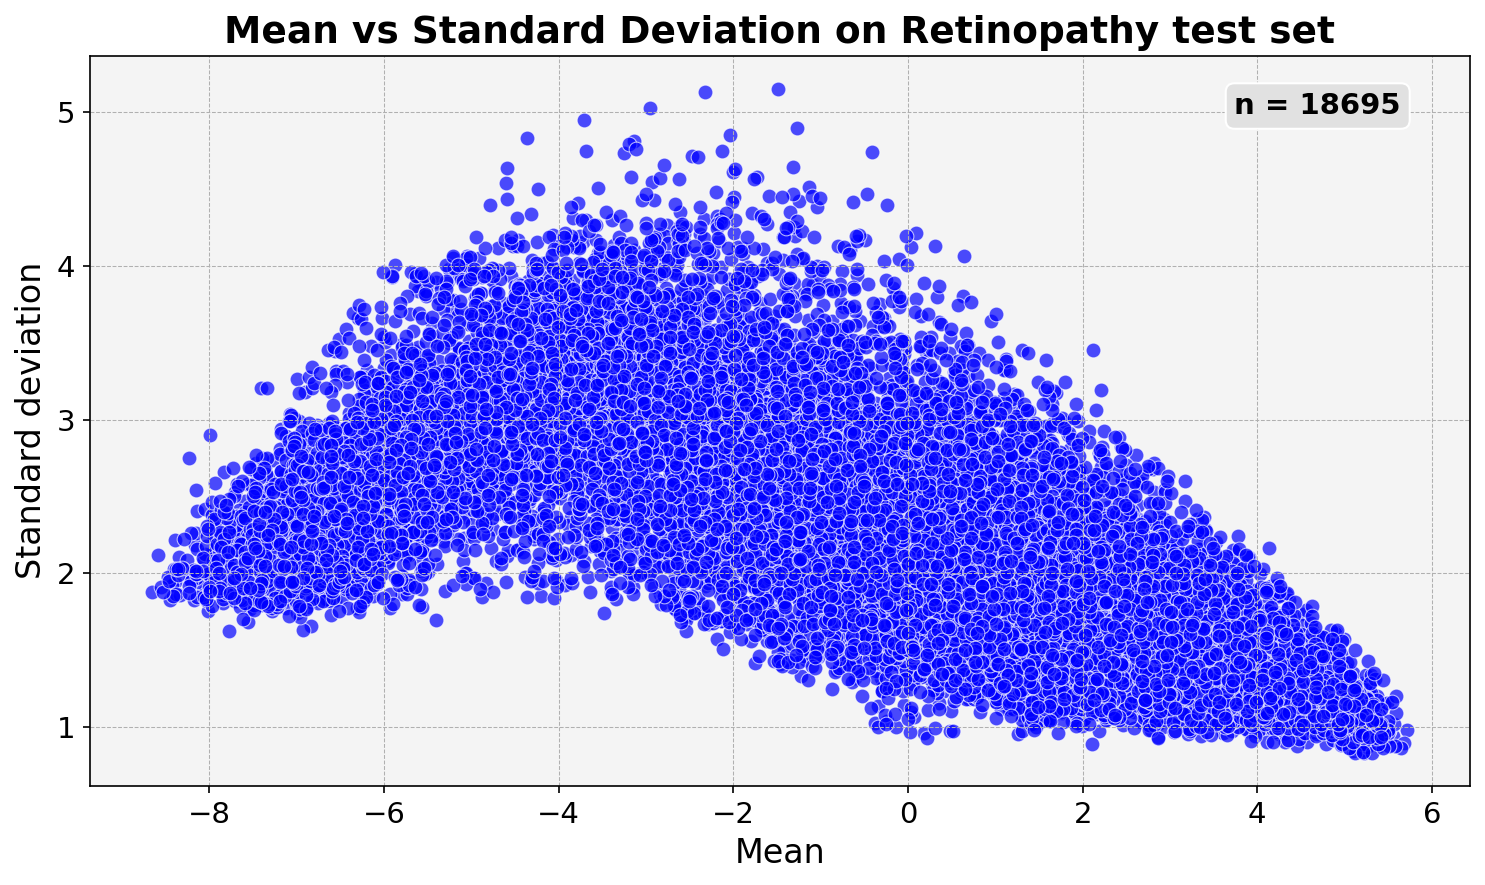

In [46]:
import matplotlib.pyplot as plt
# Create a new figure with a specified size and DPI
plt.figure(figsize=(10, 6), dpi=150)
        
        # Scatter plot with customized marker style, edgecolors and size
plt.scatter(mean_preds, std_preds, alpha=0.7, c='blue', edgecolors='w', s=50, linewidth=0.5)

        # Titles, labels with font size and weight adjustments
plt.title("Mean vs Standard Deviation on Retinopathy test set", fontsize=18, fontweight='bold')
plt.xlabel("Mean", fontsize=16)
plt.ylabel("Standard deviation", fontsize=16)
        
        # Tweak the tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
        
        # Optional: Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor("#f4f4f4")  # Set a background color

        # Annotate the number of samples
num_samples = len(mean_preds)
plt.annotate(f"n = {num_samples}", 
                    xy=(0.95, 0.95), 
                    xycoords='axes fraction',
                    fontsize=14,
                    fontweight='bold',
                    ha="right",
                    va="top",
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="#ffffff", facecolor="#e1e1e1"))


        # Make the plot tight layout
plt.tight_layout()
# compare to non active learning 4k 5k 

In [16]:
### (,-1], (-1,0], (0,2], (2,)

In [12]:
new_df = pd.DataFrame({"std": std_preds, "mean":mean_preds})
new_df

,std,mean
0,1.016849,2.457566
1,0.925848,1.462536
2,1.458347,-0.272410
3,1.164539,2.510444
4,1.415556,1.942451
...,...,...
18690,1.341310,-0.671138
18691,1.354661,-0.691605
18692,1.391587,-0.657270
18693,1.397391,-0.719562


In [13]:
bin1 = new_df[new_df['mean'] <= -1]
bin2 = new_df[(new_df['mean'] > -1) & (new_df['mean'] <= 0)]
bin3 = new_df[(new_df['mean'] > 0) & (new_df['mean'] <= 2)]
bin4 = new_df[new_df['mean'] > 2]

In [17]:
bin4

,std,mean
0,1.016849,2.457566
3,1.164539,2.510444
6,0.993802,2.416803
8,1.743004,2.888053
9,1.349648,3.424812
...,...,...
18432,1.278129,2.048813
18514,1.647492,2.963542
18538,1.902419,2.023656
18606,1.530319,2.288041


In [18]:
bin1_sorted = np.array(bin1['std'].nlargest(1250).index)
bin2_sorted = np.array(bin2['std'].nlargest(1250).index)
bin3_sorted = np.array(bin3['std'].nlargest(1250).index)
bin4_sorted = np.array(bin4['std'].nlargest(1250).index)
all_bin = np.concatenate((bin1_sorted, bin2_sorted, bin3_sorted, bin4_sorted))
all_bin.shape

(5000,)

In [19]:
activity_df = pd.read_csv(data_dir)
activity_df.iloc[all_bin].to_csv("/scratch/bclab/jiayu/CRX-Active-Learning/Data/Sampling_Test/largest_bin_samples_round2.csv", index=False)

In [12]:
# Get the indices that would sort the array
sorted_indices = np.argsort(std_preds)

# Take the last 5000 indices, which correspond to the largest 5000 numbers
largest_indices = sorted_indices[-5000:]

In [13]:
largest_indices

array([12602,  2394,  1548, ..., 13037,  8949, 15960])

In [14]:
activity_df = pd.read_csv(data_dir)
largest_seqs = activity_df.iloc[largest_indices]

In [15]:
largest_seqs.to_csv("/scratch/bclab/jiayu/CRX-Active-Learning/Data/Sampling_Test/largest_samples_round2.csv", index=False)